## Imports and dataset

In [1]:
from src.models.conjugate_bayes_lin_reg import NormalInverseGammaPriorLinearRegression
from src.models.optimized_bnn import BayesianNN
from src.utils import id, expy2, l1_projection, plot_ppds

from src.attacks.point_attacks_jax import attack

import numpy as np
import jax.numpy as jnp
import jax
import pandas as pd

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from joblib import Parallel, delayed
from tqdm import tqdm

/opt/anaconda3/envs/advReg/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", palette="muted", font="serif")

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.titleweight': 'bold',
    'axes.edgecolor': 'black',
    'axes.linewidth': 1,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'legend.fontsize': 12,
    'legend.frameon': False,
    'figure.dpi': 300,  
})

In [3]:
# set all seeds for reproducibility
seed = 42
np.random.seed(seed)

# Wine dataset

In [4]:
# Wine Quality dataset with response in {3, 4, 5, 6, 7, 8}, 11 features and 4898 samples

# URL to the Wine Quality dataset (for example, from UCI Machine Learning Repository)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
# Load the dataset directly into a Pandas DataFrame
data = pd.read_csv(url, delimiter=";")

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

In [5]:
# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

In [6]:
import numpyro
numpyro.set_host_device_count(88)

In [7]:
# Fit the model
model = BayesianNN(input_dim=X_train.shape[1], hidden_units=3)
try:
    model.load('../src/models/weights/wine/b3nn')
except FileNotFoundError:   
    print('Not model found, fitting the model') 
    model.fit(
        X_train, 
        y_train,
        num_warmup=500,
        num_samples=1000,
        num_chains=88,
    )
    model.save('../src/models/weights/wine/b3nn')

In [8]:
model.sample_predictive_distribution(jnp.array(X_test[17,:]).reshape(1, -1), 1000).mean()

Array(5.8508906, dtype=float32)

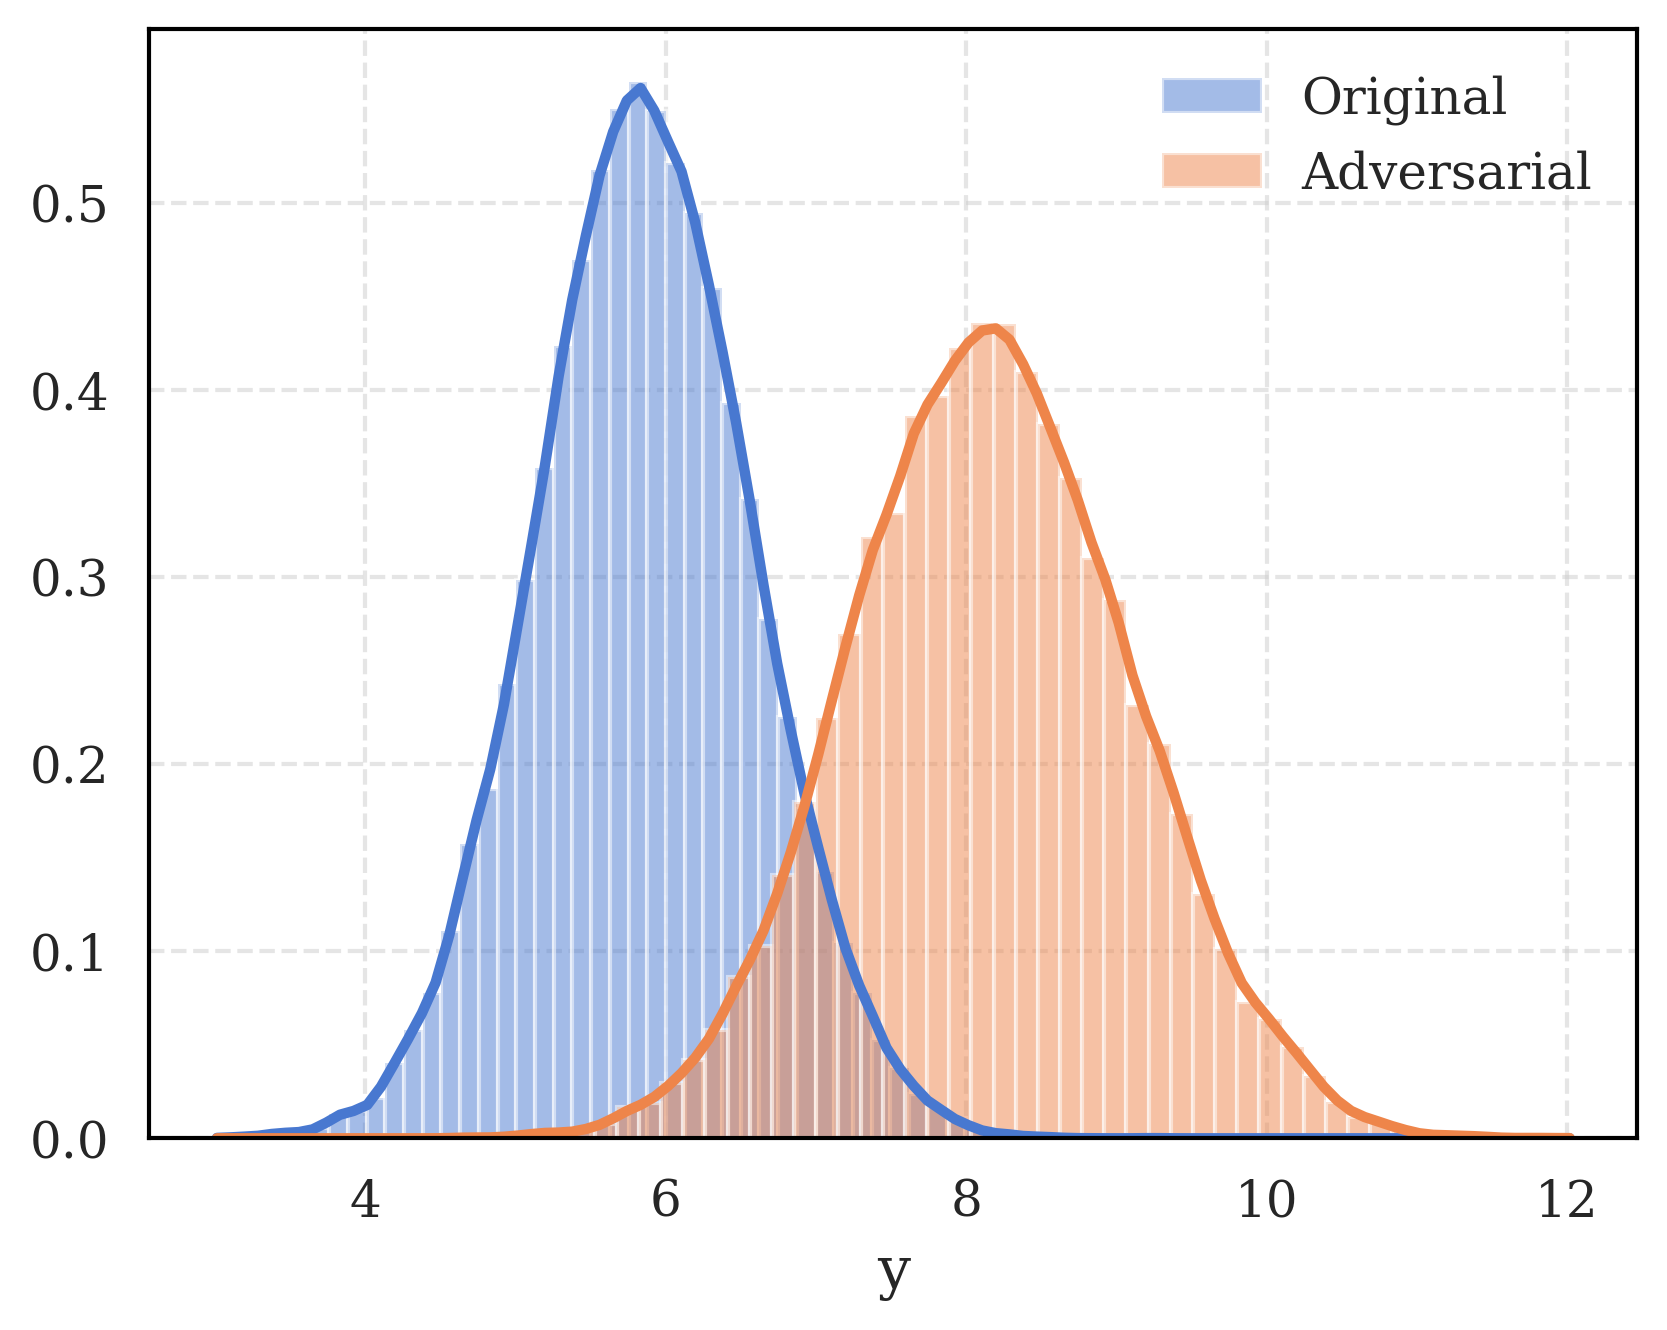

In [9]:
y_star = model.sample_predictive_distribution(jnp.array(X_test[17,:]).reshape(1, -1), 1000).mean() + 2.5
epsilon = 0.5
x = jnp.array(X_test[17,:].reshape(1, -1))
x_adv_values, loss_values, func_values = attack(x, model, y_star, epsilon=epsilon, func=id, num_iterations=100, samples_per_iteration=10, learning_rate=.1)  
y_adv_sample = model.sample_predictive_distribution(jnp.array(x_adv_values[-1]), 1000)
plot_ppds(model, x, x_adv_values[-1], jax.random.PRNGKey(42))

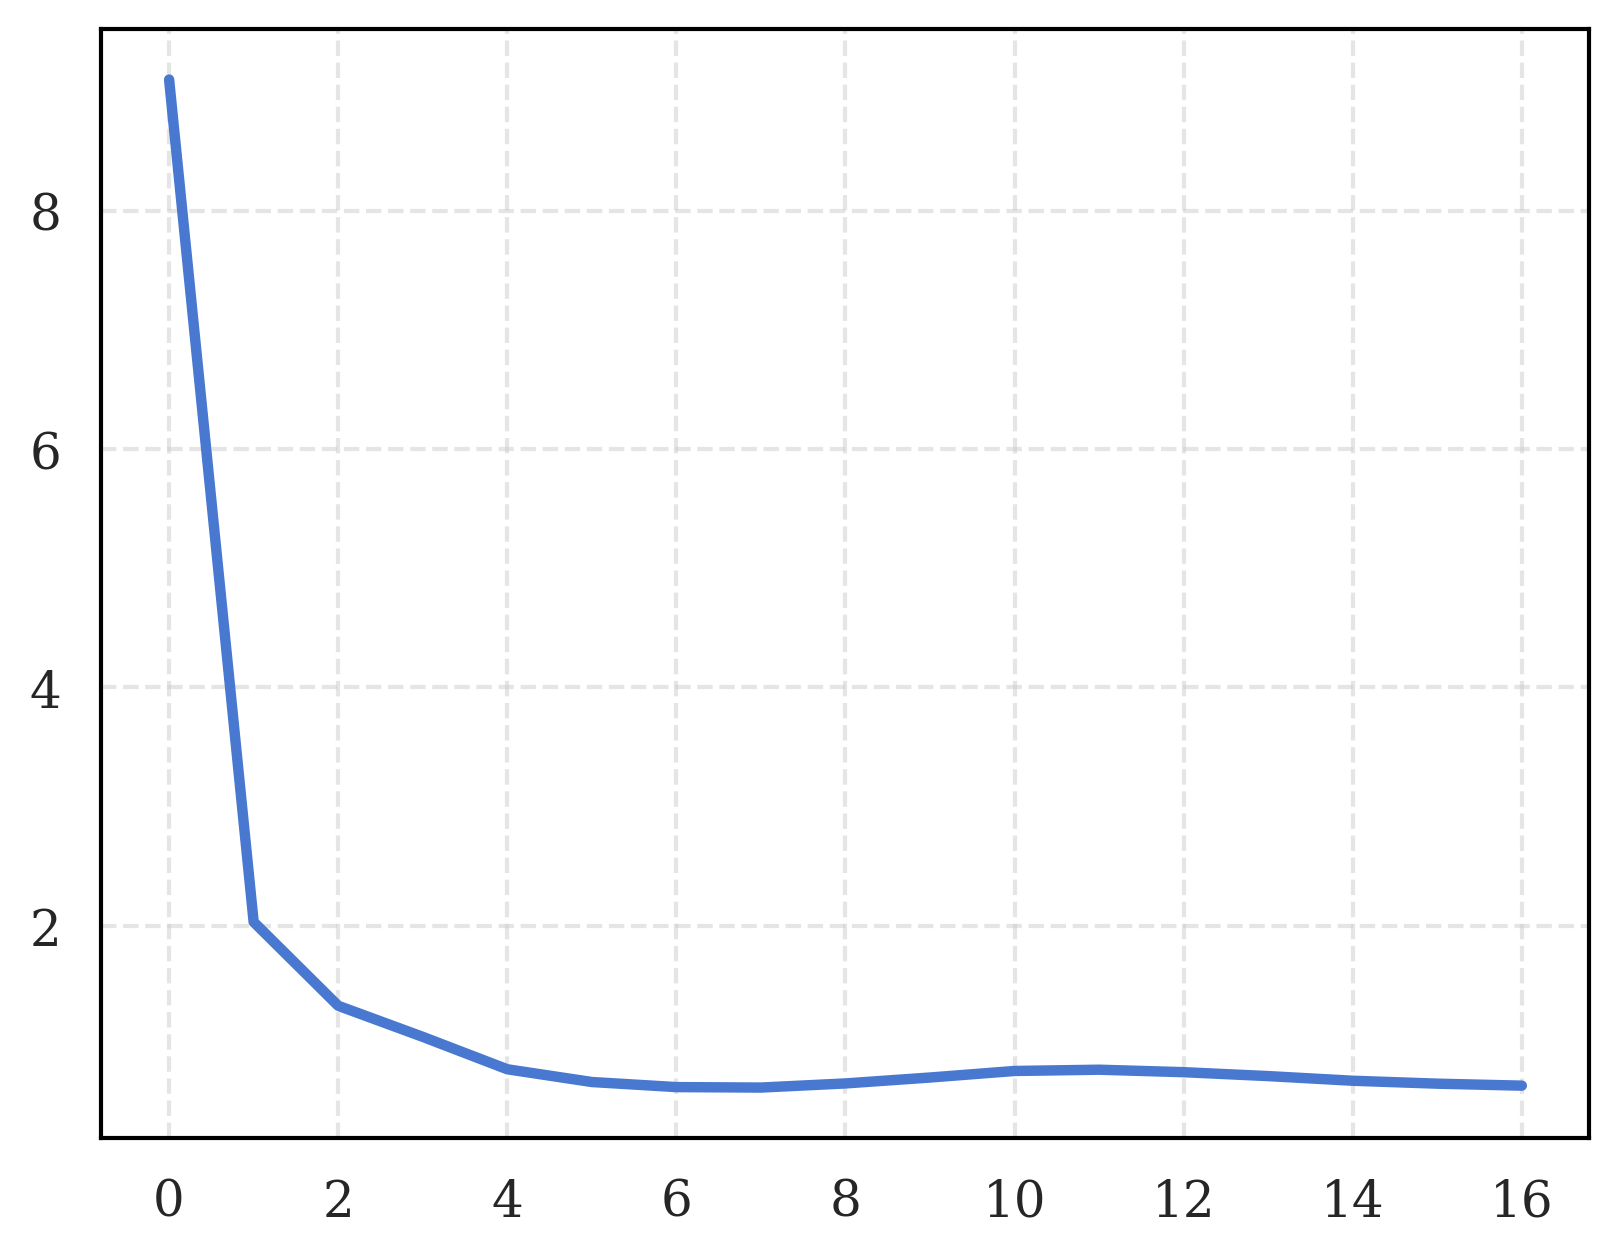

In [10]:
plt.plot(loss_values)

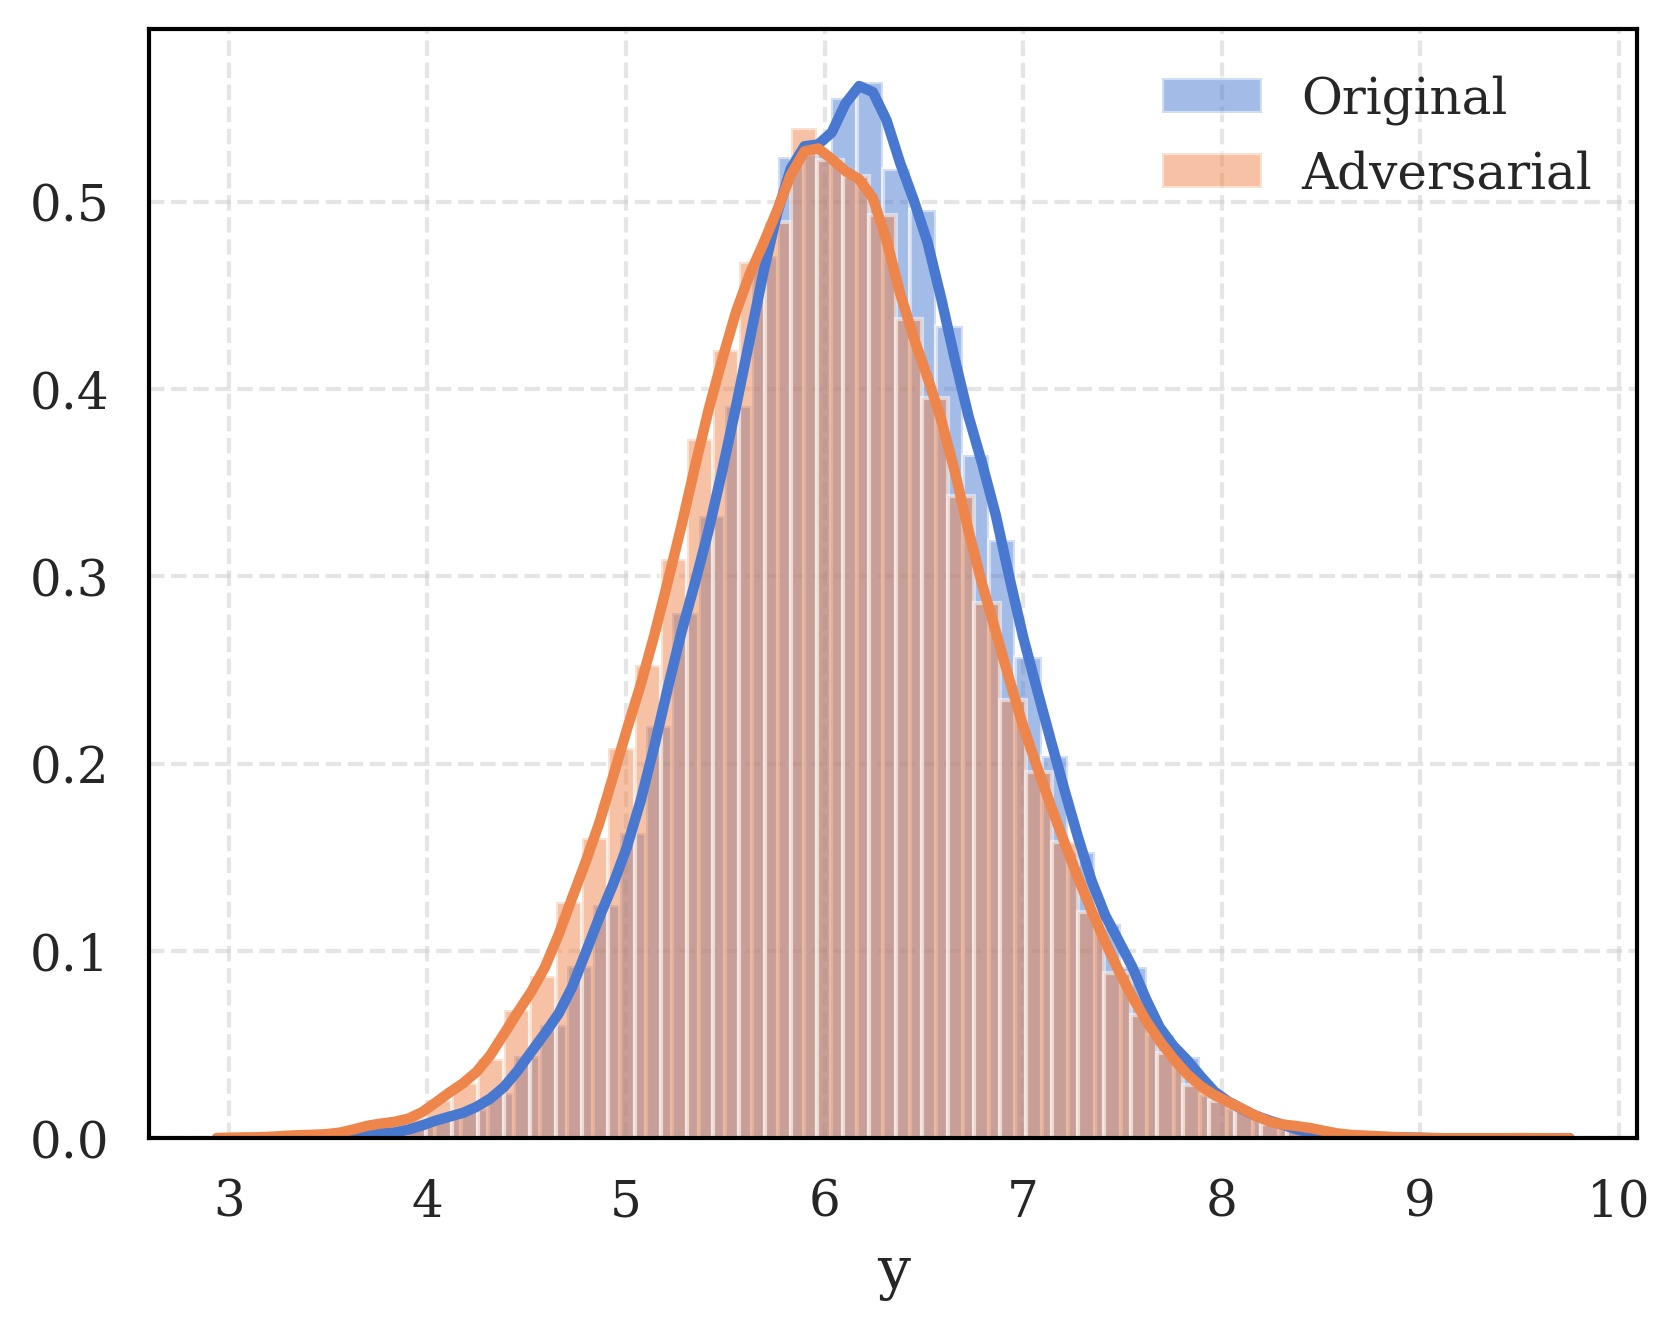

In [29]:
y_star = model.sample_predictive_distribution(jnp.array(X_test[18,:]).reshape(1, -1), 1000).var() * .2
epsilon = 0.5
def f(x, y):  # sample variance
    return y.var()
x = jnp.array(X_test[18,:]).reshape(1, -1)
x_adv_values, loss_values, func_values = attack(x, model, y_star, epsilon=epsilon, func=f, num_iterations=400, samples_per_iteration=100, learning_rate=.1)  
y_adv_sample = model.sample_predictive_distribution(jnp.array(x_adv_values[-1]), 1000)
plot_ppds(model, x, x_adv_values[-1], jax.random.PRNGKey(42))

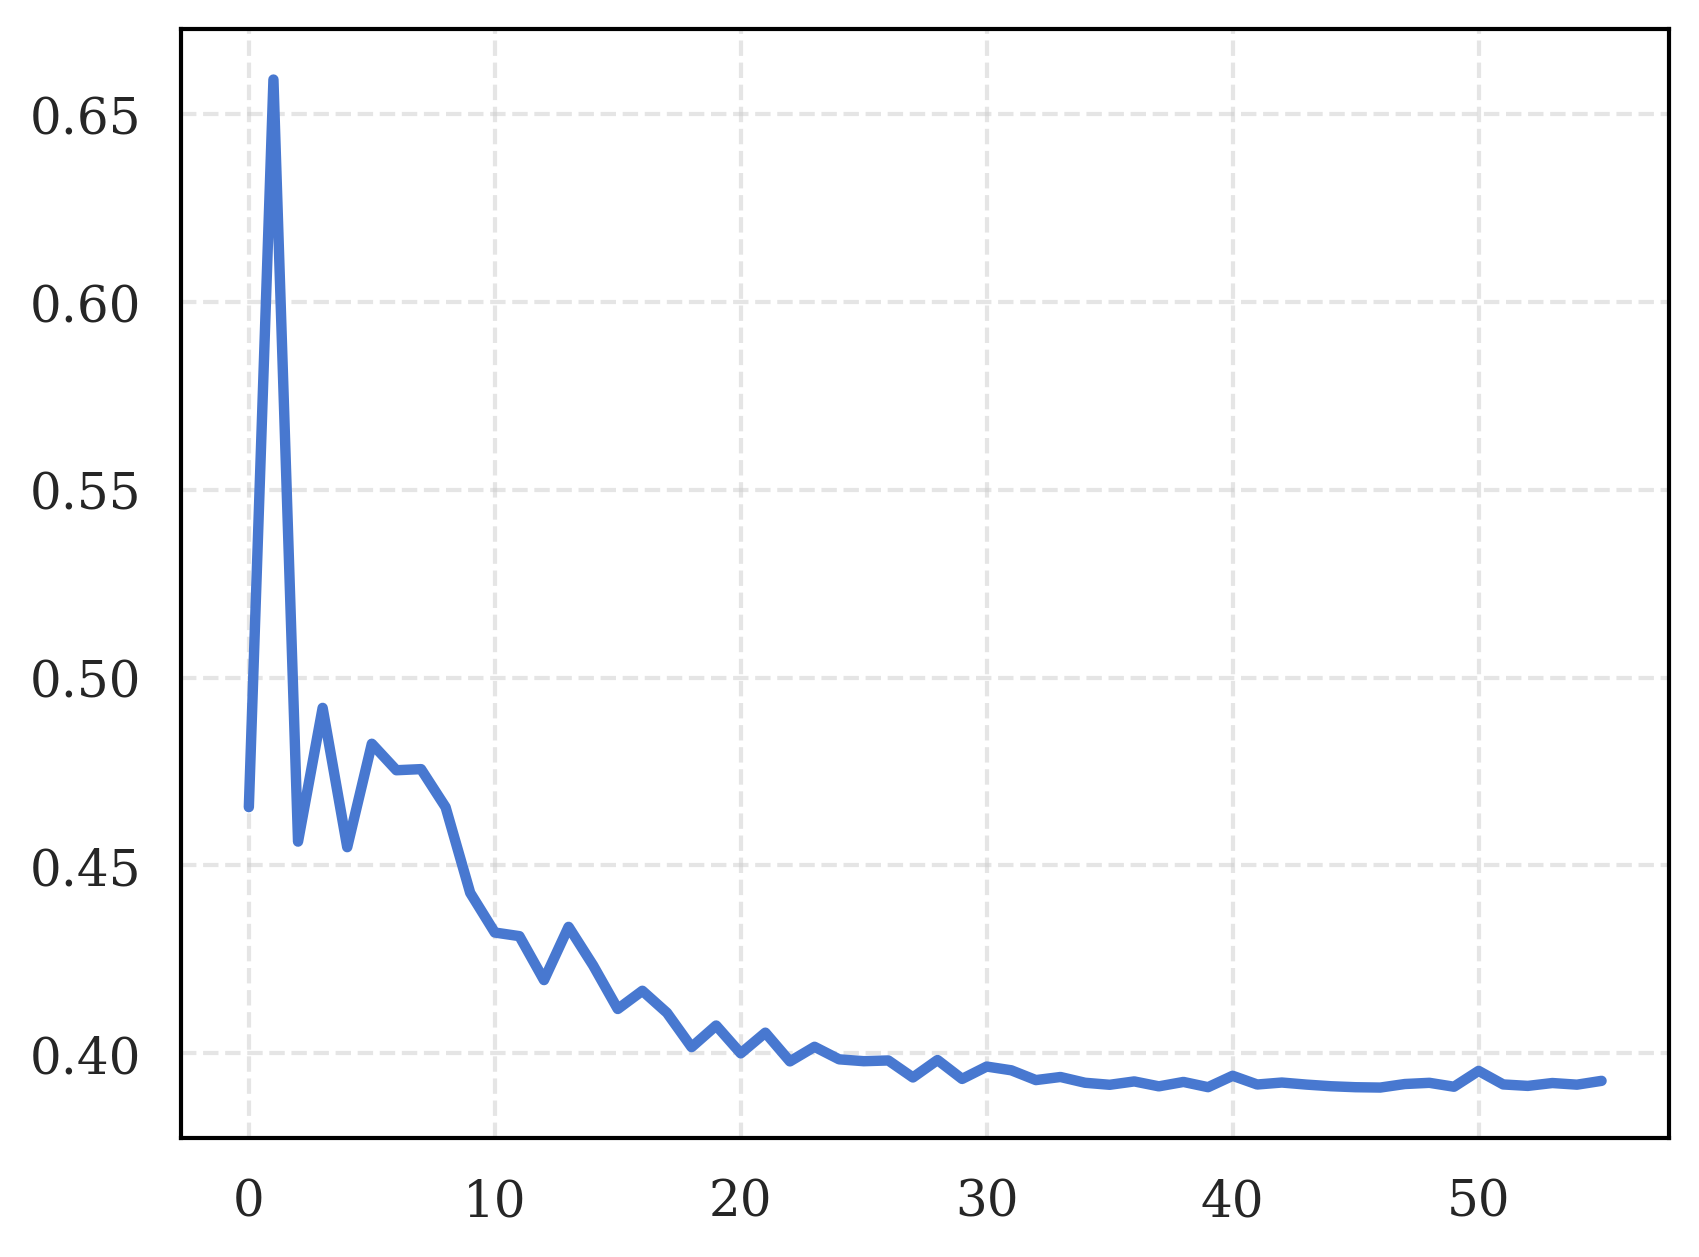

In [30]:
plt.plot(func_values)

## Attack with mean as objective function

In [ ]:
# Plot loss as a function of the size of the perturbation for both deterministic and reparametrization trick attacks
epsilons = np.linspace(0, .5, 10)
y_star = 9.0

losses_rep = []

for epsilon in tqdm(epsilons):
    x_adv = jnp.array(X_test[17,:]).reshape(1, -1)
    x_adv_values, loss_values, func_values = attack(x_adv, model, y_star, epsilon=epsilon, learning_rate=1e-4, func=id)  
    y_adv = model.sample_predictive_distribution(jnp.array(x_adv_values[-1]), 1000).mean()
    losses_rep.append((y_adv - y_star) ** 2)

# plot the mean and std of the losses
plt.errorbar(epsilons, losses_rep, label='Reparametrization trick')
plt.xlabel('$\epsilon$')
plt.ylabel('Loss')
plt.legend()

<>:15: SyntaxWarning: invalid escape sequence '\e'
<>:15: SyntaxWarning: invalid escape sequence '\e'
/var/folders/xf/gv8n8flx2xv_bvk7b5qpnnsm0000gn/T/ipykernel_94975/2087734218.py:15: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon$')
 20%|██        | 2/10 [07:39<30:36, 229.61s/it]
/var/folders/xf/gv8n8flx2xv_bvk7b5qpnnsm0000gn/T/ipykernel_94975/2087734218.py:15: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon$')


KeyboardInterrupt: 

In [ ]:
# Plot loss as a function of the size of the perturbation for both deterministic and reparametrization trick attacks
losses_rep_all = []
losses_fgsm_all = []
epsilons = np.linspace(0, .5, 10)
y_star = 9.0

for _ in range(4):
    losses_rep = []

    for epsilon in epsilons:
        x_adv = jnp.array(X_test[17,:]).reshape(1, -1)
        x_adv_values, loss_values, func_values = attack(x_adv, model, y_star, epsilon=epsilon, learning_rate=1e-4, func=id)  
        y_adv = model.sample_predictive_distribution(jnp.array(x_adv_values[-1]), 1000).mean()
        losses_rep.append((y_adv - y_star) ** 2)
    losses_rep_all.append(losses_rep)

# plot the mean and std of the losses
plt.errorbar(epsilons, np.mean(losses_rep_all, axis=0), yerr=2*np.std(losses_rep_all, axis=0), label='Reparametrization trick')
plt.xlabel('$\epsilon$')
plt.ylabel('Loss')
plt.legend()

<>:19: SyntaxWarning: invalid escape sequence '\e'
<>:19: SyntaxWarning: invalid escape sequence '\e'
/var/folders/xf/gv8n8flx2xv_bvk7b5qpnnsm0000gn/T/ipykernel_94975/2360484299.py:19: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon$')
/var/folders/xf/gv8n8flx2xv_bvk7b5qpnnsm0000gn/T/ipykernel_94975/2360484299.py:19: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon$')


KeyboardInterrupt: 

## Attack with exp(y^2/100) as objective function

In [ ]:
ys = model.sample_predictive_distribution(jnp.array(X_test[17,:]).reshape(1, -1), 1000)
func = jnp.exp(ys ** 2 / 100)
func.mean()

In [ ]:
# Plot loss as a function of the size of the perturbation for reparametrization trick attack
x_adv = jnp.array(X_test[17,:]).reshape(1, -1)
y_star = 3.0
losses_total_rep = []
losses_total_fgsm = []
epsilons = np.linspace(0, .8, 10)

def compute_loss_rep(epsilon):
    x_adv_values, loss_values, func_values = attack(x_adv, model, y_star, epsilon=epsilon, learning_rate=1e-4, num_iterations=1000, samples_per_iteration=1000, func=expy2)    
    y_adv = model.sample_predictive_distribution(jnp.array(x_adv_values[-1]), 1000)
    func_mean = jnp.exp(y_adv ** 2 / 100).mean()
    return (func_mean - y_star) ** 2


for _ in range(4):
    print(_)
    losses_rep = []

    for epsilon in epsilons:
        losses_rep.append(compute_loss_rep(epsilon))
        
    losses_total_rep.append(losses_rep)

# plot the mean and std of the losses
plt.errorbar(epsilons, np.mean(losses_total_rep, axis=0), yerr=2*np.std(losses_total_rep, axis=0), label='Reparametrization trick')
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('Loss')

#### Compare attacking one point with l1 or l2 projection

In [ ]:
x = jnp.array(X_test[17,:]).reshape(1, -1)
y_star = 3.0
x_adv_values, loss_values, func_values = attack(x, model, y_star, epsilon=0.3, learning_rate=1e-4, num_iterations=1000, samples_per_iteration=1000, func=expy2, projection=l1_projection)
x_adv_l1 = x_adv_values[-1]
x_adv_values, loss_values, func_values = attack(x, model, y_star, epsilon=0.3, learning_rate=1e-4, num_iterations=1000, samples_per_iteration=1000, func=expy2)
x_adv_l2 = x_adv_values[-1]
print(x,'\n', x_adv_l1,'\n', x_adv_l2)
print(x-x_adv_l1, '\n', x-x_adv_l2)